In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label='', grad=''): #children is a tuple
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children) #tuple stored as a set
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += out.grad
            other.grad += out.grad #dL/dother = dL/dout * dout/dother = dL/dout * 1 = out.grad
        out._backward = _backward
        
        return out
   
    def __radd__(self, other):
        return self + other
        
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data #dL/dother = dL/dout * dout/dother = dL/dout * d(self * other)/dother = out.grad * self = out.grad
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other): #self/other = self * (other**-1)
        return self * other**-1
    
    def __pow__(self, other): #self**other
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**o{other}')

        def _backward():
            self.grad += out.grad * other * (self.data ** (other - 1))# x^2 -> 2x^1
        out._backward = _backward
        
        return out
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += out.grad * (1 - t**2) #dL/dself = dL/dout * dout/dself = dL/dout * d(tanh(self))/dself = out.grad * (1 - tanh**2(self))
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad += out.grad * out.data #dL/dself = dL/dout * dout/dself
        out._backward = _backward
        
        return out
    
    
    def backward(self):        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [3]:
a = Value(1.0)
b = Value(2.0)
a-b

Value(data=-1.0)

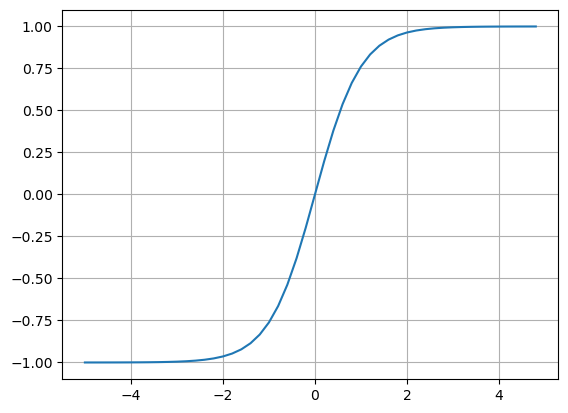

In [4]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)));
plt.grid();

In [5]:
#inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b') #bias
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n' #all weights added, without activation function

e = (2*n).exp()
o = (e - 1)/(e + 1)

In [6]:
o.backward()
print(x1.grad, w1.grad, x2.grad, w2.grad)

-1.5 1.0 0.5 0.0


In [7]:
import torch
import random

In [8]:
x1 = torch.Tensor([2.0]).double();                  x1.requires_grad = True
x2 = torch.Tensor([0.0]).double();                  x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double();                 w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();                  w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double();    b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward() 
print('---')


print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [9]:
class Neuron:
    
    def __init__(self, nin): #number of inputs to a nueron
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1)) 
        
    def __call__(self, x):
        #w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b] #list of weights for each number in the input

class Layer:
    
    #creates a list of neurons, where each Neuron has nin number of elems
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)] 
        
    #applies activation function to each Neuron, outputs a layer of "activated neurons"
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        #matrix - list of params for each neuron
        return [p for neuron in self.neurons for p in neuron.parameters()] 

class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [16]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.0775776874442727)

In [18]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0] #desired targets
ypred

[Value(data=0.9553033462839272),
 Value(data=-0.9686813993641871),
 Value(data=-0.9126222386309466),
 Value(data=0.9138509156778617)]

In [13]:
for k in range(20):
    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    loss
    
    #backward pass
    for p in n.parameters():
        p.grad = 0
    loss.backward()
    
    #update
    for p in n.parameters():
        p.data += -0.1 * p.grad
    
    print(k, loss.data)

0 7.567669324937413
1 5.35163122059849
2 1.3717664116530643
3 0.5232697272223047
4 0.1328672122094652
5 0.09171099056625065
6 0.0717613817238342
7 0.05899417774358762
8 0.050012185251934904
9 0.043336448346051264
10 0.03818140701879926
11 0.03408397559746218
12 0.030751925489735717
13 0.027991398404649342
14 0.025668669154057626
15 0.02368851695798824
16 0.02198131903310138
17 0.020495010481716418
18 0.019189893579436797
19 0.018035183510610203


In [14]:
ypred

[Value(data=0.9553033462839272),
 Value(data=-0.9686813993641871),
 Value(data=-0.9126222386309466),
 Value(data=0.9138509156778617)]